In [147]:
import xarray as xr # to handle netcdf data cubes
import matplotlib.pyplot as plt # for plotting
import os # to access files, folder and paths
from os import listdir
import numpy as np
import pyproj
import rasterio
import glob

In [148]:
# import lac data
full_ds = xr.open_mfdataset('/scratch/sdupuis/GP_3/Svartaberg_10_05_2023/2018/metop1/2018/*.nc', concat_dim='time', combine='nested', engine='netcdf4')

In [149]:
full_ds

<xarray.Dataset>
Dimensions:      (time: 458, y: 50, x: 86)
Coordinates:
  * x            (x) float64 19.0 19.02 19.03 19.04 ... 19.98 19.99 20.01 20.02
  * y            (y) float64 64.54 64.53 64.52 64.5 ... 63.99 63.98 63.97 63.96
  * time         (time) datetime64[ns] 2018-01-01T10:00:03.800000 ... 2018-12...
    spatial_ref  int64 0
Data variables:
    azimuthdiff  (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image0       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image1       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image2       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image3       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image4       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image5       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    satazimuth   (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    satzenith    (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    sunazimuth   (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    sunzenith    (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    CMA_prob     (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
Attributes: (12/21)
    description:                            AVHRR-3 1
    id_tag:                                 ch_r06
    sun_earth_distance_correction_applied:  True
    sun_zenith_angle_correction_applied:    True
    calib_coeffs_version:                   PATMOS-x, v2017r1
    calibration:                            reflectance
    ...                                     ...
    platform:                               metop1
    platform_name:                          metop1
    sensor:                                 avhrr
    source:                                 rsgb eu1km v04
    start_time:                             2018-01-01 09:53:03
    Conventions:                            CF-1.7

In [150]:
time_series =  full_ds.sel(y = 64.2443, x = 19.7663, method='nearest')

In [151]:
time_series = time_series.sortby("time")

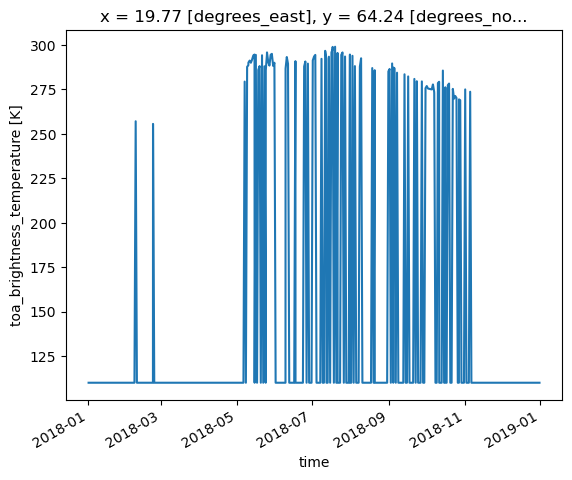

In [152]:
time_series['image4'].plot();

In [153]:
# so clouds have a value of 110
# Winter doesn't seem very interesting here, maybe take the mean of several pixels could help

In [154]:
# to compute LST we need first to obtain emissivity, there are 3 options:
# 1) Get Emissivity as a fixed value over time. For example the ASTER Global Emissivity Dataset (GED) Product provides emissivity 
# https://lpdaac.usgs.gov/news/aster-global-emissivity-dataset-ged-product-release/
#  -> use NASA EARTHDATA search portal and select the relevant tile
# https://search.earthdata.nasa.gov/search/granules?p=C2763266348-LPCLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&g=G2817994080-LPCLOUD&q=ASTER%20GED&sb[0]=6.9873%2C45.66277%2C8.38477%2C46.65173&tl=1739441110.043!3!!&lat=46.97255320979872&long=5.86669921875&zoom=7
# 2) Get emissivity from litterature values
# -> option showed below

# 3) get AVHRR LAC emissivity values




In [155]:
# Emissivities (Hulley et al., 2014)

# Water
water_4 = 0.991 # class 210
water_5 = 0.987

# Snow (Hulley 2014)
snow_4 = 0.989 # 220
snow_5 = 0.982

# Permanent snow and Ice (Hulley 2014)
# Ice
ice_4 = 0.98
ice_5 = 0.953


# emissivity values from literature (Sobrino et al. 2001)
e_bare_soil_ch4 = 0.95
e_bare_soil_ch5 = 0.96

# emissivity for both channels is roughly the same for very dense vegetation
e_vegetation = 0.99

In [156]:
# Emissivites (from Pinhero et al. 2006) JPL spectral libraires
mixed_forest = 0.982
broad_l_f_ch4 = 0.974
broad_l_f_ch5 = 0.973
coniferous_f_ch4 = 0.989
coniferious_f_ch5 = 0.991
woodland_shrubs = 0.982
arable_land_ch4 = 0.982 # sport, green urban area.
arable_land_ch5 = 0.989
urban_Area_ch4 = 0.964  # goita et al. 1997 / 0.95 Monika J. Hajto1* 2013
urban_Area_ch5 = 0.973 #/0.96 Monika J. Hajto 2013

### Land Cover (Copernicus ICDR Land Cover 2016-2020)

In [157]:
# how to load a land cover for example and verify which land cover unit corresponds to your pixel. 
land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/Copernicus_land_cover/C3S-LC-L4-LCCS-Map-300m-P1Y-2016-v2.1.1.nc', engine='netcdf4')

In [158]:
land_cover

<xarray.Dataset>
Dimensions:              (time: 1, lat: 64800, lon: 129600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 90.0 90.0 89.99 ... -89.99 -90.0 -90.0
  * lon                  (lon) float64 -180.0 -180.0 -180.0 ... 180.0 180.0
  * time                 (time) datetime64[ns] 2016-01-01
Dimensions without coordinates: bounds
Data variables:
    lccs_class           (time, lat, lon) uint8 ...
    processed_flag       (time, lat, lon) float32 ...
    current_pixel_state  (time, lat, lon) float32 ...
    observation_count    (time, lat, lon) uint16 ...
    change_count         (time, lat, lon) uint8 ...
    crs                  int32 ...
    lat_bounds           (lat, bounds) float64 ...
    lon_bounds           (lon, bounds) float64 ...
    time_bounds          (time, bounds) datetime64[ns] ...
Attributes: (12/38)
    id:                         C3S-LC-L4-LCCS-Map-300m-P1Y-2016-v2.1.1
    title:                      Land Cover Map of 2016
    summary:                    This dataset characterizes the land cover of ...
    type:                       C3S-LC-L4-LCCS-Map-300m-P1Y
    project:                    EC C3S Land cover
    references:                 https://cds.climate.copernicus.eu/
    ...                         ...
    geospatial_lon_max:         null
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [159]:
# for exmaple, for our selected point of interest, the land cover is 70, which corresponds to : Tree cover, needleleaved, so emissivity corresponds to 
# coniferous_f_ch4 = 0.989 and coniferious_f_ch5 = 0.991
land_cover['lccs_class'].sel(lat = 64.2443, lon = 19.7663, method='nearest').values

array([70], dtype=uint8)

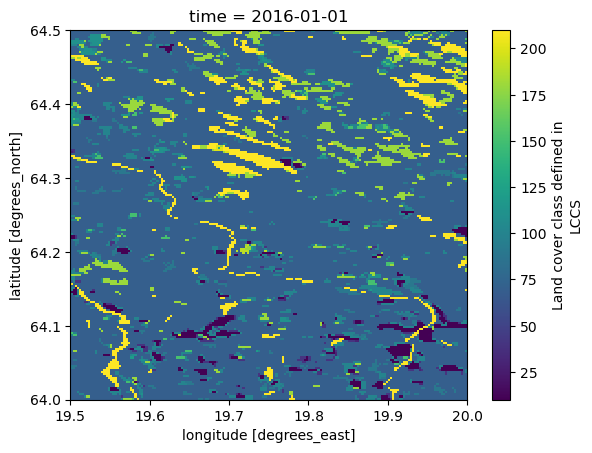

In [160]:
# You can also plot the area to see if the land cover is homogeneous
# Here the the land cover presents forest, but also water bodies, so the satellite signal migt very easily be contaminated by water. Note that the land cover 
# has a much finer resolution (300m) than the satellite image (1km).
land_cover['lccs_class'].sel(lat = slice(64.5, 64), lon =slice(19.5,20)).plot();

### LST retrieval

LST computation as described by Pinheiro et al., 2006 (proposed by Uliveri 1994, and recommended by Vazqzez 1997 and Qin 2004).
See reference below. This is a simplified split-window methodology with empirical coefficients.


[1] A.C.T. Pinheiro, R. Mahoney, J.L. Privette, C.J. Tucker,

Development of a daily long term record of NOAA-14 AVHRR land surface temperature over Africa,

Remote Sensing of Environment,

Volume 103, Issue 2,

2006,

Pages 153-164,

ISSN 0034-4257,

https://doi.org/10.1016/j.rse.2006.03.009.

(https://www.sciencedirect.com/science/article/pii/S0034425706001192)

**Abstract**: We developed a new 6-year daily, daytime and nighttime, NOAA-14 AVHRR based land surface temperature (LST) dataset over continental Africa for the period 1995 through 2000. The processing chain was developed within the Global Inventory Modeling and Mapping System (GIMMS) at NASA's Goddard Space Flight Center. This paper describes the processing methodology used to convert the Global Area Coverage Level-1b data into LST and collateral data layers, such as sun and view geometries, cloud mask, local time of observation, and latitude and longitude. We used the Ulivieri et al. [Ulivieri, C., M.M. Castronuovo, R. Francioni, and A. Cardillo (1994), A split window algorithm for estimating land surface temperature from satellites, Adv. Space Research, 14(3):59–65.] split window algorithm to determine LST values. This algorithm requires as input values of surface emissivity in AVHRR channels 4 and 5. Thus, we developed continental maps of emissivity using an ensemble approach that combines laboratory emissivity spectra, MODIS-derived maps of herbaceous and woody fractional cover, and the UNESCO FAO soil map. A preliminary evaluation of the resulting LST product over a savanna woodland in South Africa showed a bias of <0.3 K and an uncertainty of <1.3 K for daytime retrievals (<2.5 K for night). More extensive validation is required before statistically significant uncertainties can be determined. The LST production chain described here could be adapted for any wide field of view sensor (e.g., MODIS, VIIRS), and the LST product may be suitable for monitoring spatial and temporal temperature trends, or as input to many process models (e.g., hydrological, ecosystem).
Keywords: Land surface temperature; Advanced Very High Resolution Radiometer; Global Area Coverage; Split window algorithm; Africa


In [161]:
# Remove clouds first, value of 110 means cloud cover
no_clouds = time_series.where(time_series['image4']>110)

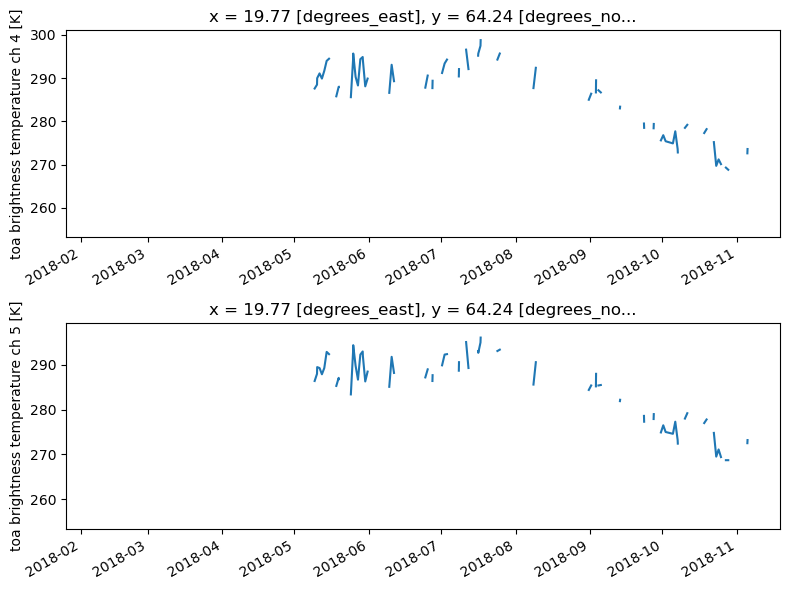

In [162]:
# plot to verify that cloud removal worked

f, (ax1, ax2)= plt.subplots(2, 1, figsize=(8, 6))
no_clouds['image4'].plot(ax=ax1);
ax1.set_xlabel("")
ax1.set_ylabel("toa brightness temperature ch 4 [K]")
no_clouds['image5'].plot(ax=ax2);
ax2.set_xlabel("")
ax2.set_ylabel("toa brightness temperature ch 5 [K]")
plt.tight_layout();


In [163]:
# compute mean and emissivity difference
diff_em = coniferous_f_ch4 - coniferious_f_ch5
e_mean = (coniferous_f_ch4 + coniferious_f_ch5)/2
LST = no_clouds['image4']+1.8*(no_clouds['image4']-no_clouds['image5'])+ 48*(1-e_mean) -75*diff_em


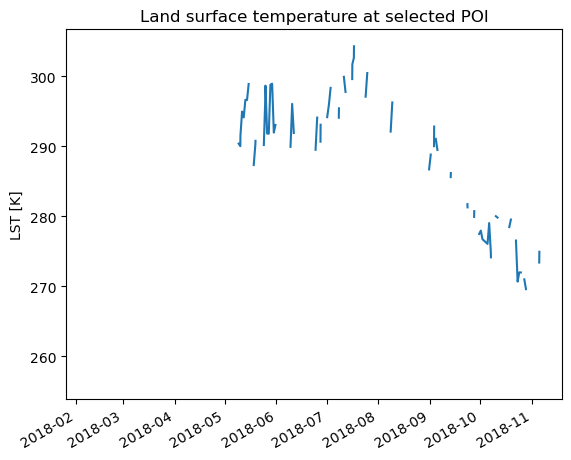

In [164]:
# plot the obtained LST
LST.plot();
plt.title('Land surface temperature at selected POI');
plt.ylabel('LST [K]')
plt.xlabel('');

In [165]:
# you can also decide to take the mean of several pixels (if the area is homogeneous)

In [166]:
def get_pixels(ds, lat, lon):
    ilon =list(ds.x.values).index(ds.sel(x=lon, method='nearest').x)
    ilat =list(ds.y.values).index(ds.sel(y=lat, method='nearest').y)
    return ilon, ilat

In [167]:
y = 64.2443
x = 19.7663
ilon, ilat = get_pixels(full_ds, y, x)
window_3x3_ch4 = full_ds['image4'][:,[ilat+1,ilat,ilat-1],[ilon-1,ilon,ilon+1]]
window_3x3_no_clouds_ch4 = window_3x3_ch4.where(window_3x3_ch4 > 110)
mean_ch4 = window_3x3_no_clouds_ch4.mean(dim=['y','x'])

In [168]:
ilon, ilat = get_pixels(full_ds, y, x)
window_3x3_ch5 = full_ds['image4'][:,[ilat+1,ilat,ilat-1],[ilon-1,ilon,ilon+1]]
window_3x3_no_clouds_ch5 = window_3x3_ch5.where(window_3x3_ch4 > 110)
mean_ch5 = window_3x3_no_clouds_ch4.mean(dim=['y','x'])

In [169]:
mean_ch4

<xarray.DataArray 'image4' (time: 458)>
dask.array<mean_agg-aggregate, shape=(458,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T10:00:03.800000 ... 2018-12...
    spatial_ref  int64 0

In [170]:
# Compute LST for mean of area
LST_mean_AOI = mean_ch4+1.8*(mean_ch4-mean_ch5)+ 48*(1-e_mean) -75*diff_em

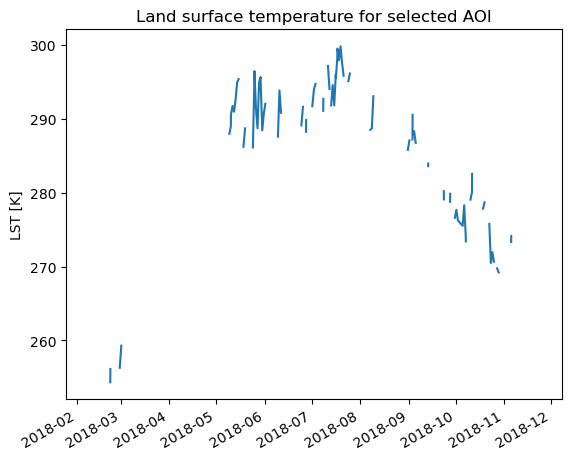

In [171]:
# plot the obtained LST
LST_mean_AOI.plot();
plt.title('Land surface temperature for selected AOI');
plt.ylabel('LST [K]')
plt.xlabel('');

In [172]:
# you can also take the mean accross a larger area
# Remove clouds first, value of 110 means cloud cover
no_clouds_AOI = full_ds.where(full_ds['image4']>110)
large_AOI =  no_clouds_AOI.mean(dim=['x', 'y'])

In [173]:
large_AOI

<xarray.Dataset>
Dimensions:      (time: 458)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T10:00:03.800000 ... 2018-12...
    spatial_ref  int64 0
Data variables:
    azimuthdiff  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    image0       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    image1       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    image2       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    image3       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    image4       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    image5       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    satazimuth   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    satzenith    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sunazimuth   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sunzenith    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CMA_prob     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [174]:
LST_AOI = large_AOI['image4']+1.8*(large_AOI['image4']-large_AOI['image5'])+ 48*(1-e_mean) -75*diff_em

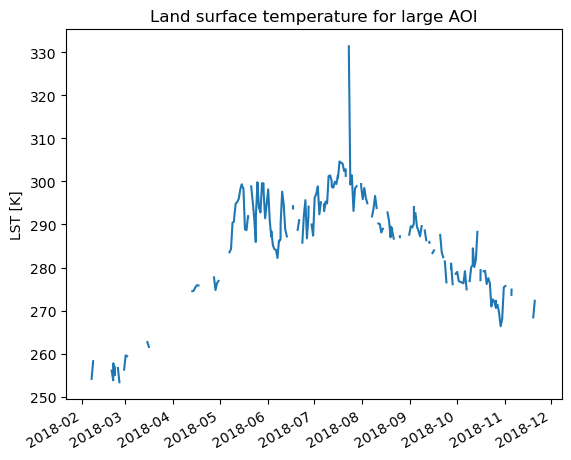

In [175]:
# plot the obtained LST
LST_AOI.plot();
plt.title('Land surface temperature for large AOI');
plt.ylabel('LST [K]')
plt.xlabel('');

In [176]:
# here there is an outlier in the time series, which can be filtered out by setting a threshold for example

LST_AOI_filtered = LST_AOI.where(LST_AOI<310)

In [177]:
LST_AOI_filtered

<xarray.DataArray (time: 458)>
dask.array<where, shape=(458,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T10:00:03.800000 ... 2018-12...
    spatial_ref  int64 0

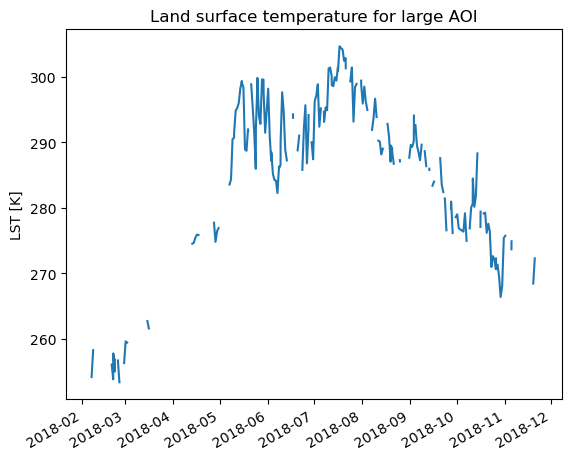

In [178]:
# plot the obtained LST
LST_AOI_filtered.plot();
plt.title('Land surface temperature for large AOI');
plt.ylabel('LST [K]')
plt.xlabel('');

In [179]:
# do daily means with groupyby operation
LST_AOI_filtered.groupby("time.dayofyear")
#daily_means =  

DataArrayGroupBy, grouped over 'dayofyear'
362 groups with labels 1, 2, 3, 4, 5, ..., 362, 363, 364, 365.

In [180]:
# do daily means with groupyby operation and take the mean
daily_means = LST_AOI_filtered.groupby("time.dayofyear").mean('time')

In [181]:
# instead of 458 values, now there are only 362 values.
daily_means

<xarray.DataArray (dayofyear: 362)>
dask.array<stack, shape=(362,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * dayofyear    (dayofyear) int64 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365

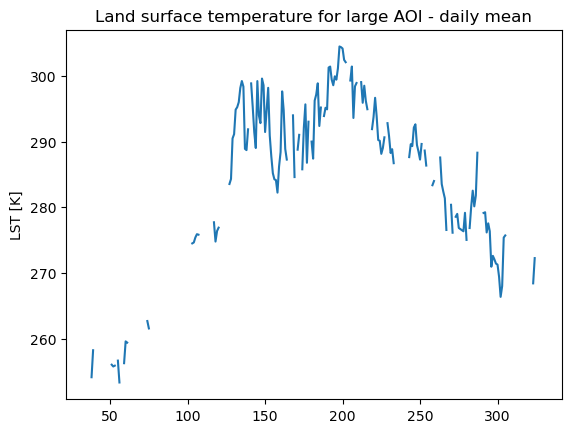

In [182]:
# plot the obtained LST
daily_means.plot();
plt.title('Land surface temperature for large AOI - daily mean');
plt.ylabel('LST [K]')
plt.xlabel('');

In [183]:
# do monthly means
monthly_means = LST_AOI_filtered.groupby("time.month").mean('time')

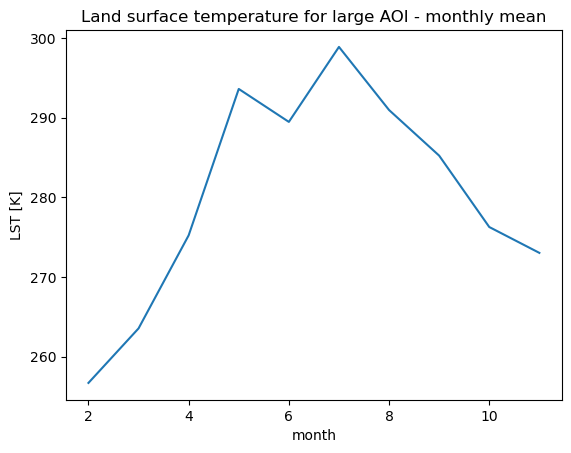

In [184]:
# plot the obtained LST
monthly_means.plot();
plt.title('Land surface temperature for large AOI - monthly mean');
plt.ylabel('LST [K]');

In [185]:
# Now, have a look at another area
# What is the temperature magnitude difference ?

### Daily temperature cycle

In [186]:
spring = LST_AOI_filtered.sel(time=slice('2018-03', '2018-05'))

In [187]:
spring

<xarray.DataArray (time: 117)>
dask.array<getitem, shape=(117,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-03-01T09:38:54.700000 ... 2018-05...
    spatial_ref  int64 0

In [188]:
daily_cycle_spring = spring.groupby("time.hour").mean("time")

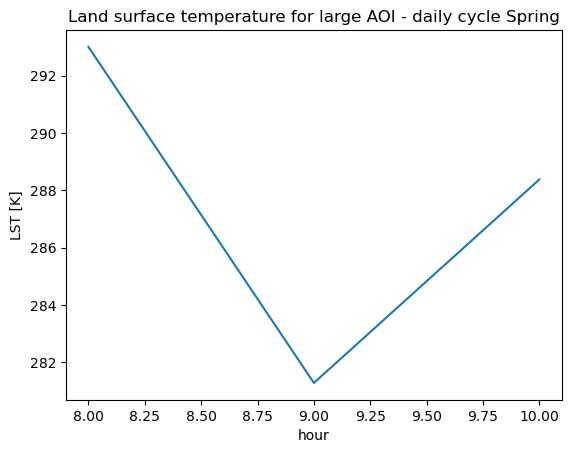

In [189]:
# plot the obtained LST
daily_cycle_spring.plot();
plt.title('Land surface temperature for large AOI - daily cycle Spring');
plt.ylabel('LST [K]');

In [190]:
# Use more satellite data 

# import lac data
metop_2 = xr.open_mfdataset('/scratch/sdupuis/GP_3/Svartaberg_10_05_2023/2018/metop2/2018/*.nc', concat_dim='time', combine='nested', engine='netcdf4')

In [191]:
noaa19 = xr.open_mfdataset('/scratch/sdupuis/GP_3/Svartaberg_10_05_2023/2018/noaa19/2018/*.nc', concat_dim='time', combine='nested', engine='netcdf4')

In [192]:
noaa18 = xr.open_mfdataset('/scratch/sdupuis/GP_3/Svartaberg_10_05_2023/2018/noaa18/2018/*.nc', concat_dim='time', combine='nested', engine='netcdf4')

In [193]:
# concat everything on the time dimension
concatenated_data = xr.concat([metop_2, full_ds, noaa18, noaa19], dim='time')

In [194]:
# the dataset has now 1908 data points
concatenated_data

<xarray.Dataset>
Dimensions:      (time: 1908, y: 50, x: 86)
Coordinates:
  * x            (x) float64 19.0 19.02 19.03 19.04 ... 19.98 19.99 20.01 20.02
  * y            (y) float64 64.54 64.53 64.52 64.5 ... 63.99 63.98 63.97 63.96
  * time         (time) datetime64[ns] 2018-01-01T09:05:16.100000 ... 2018-12...
    spatial_ref  int64 0
Data variables:
    azimuthdiff  (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image0       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image1       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image2       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image3       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image4       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    image5       (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    satazimuth   (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    satzenith    (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    sunazimuth   (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    sunzenith    (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
    CMA_prob     (time, y, x) float32 dask.array<chunksize=(1, 50, 86), meta=np.ndarray>
Attributes: (12/21)
    description:                            AVHRR-3 1
    id_tag:                                 ch_r06
    sun_earth_distance_correction_applied:  True
    sun_zenith_angle_correction_applied:    True
    calib_coeffs_version:                   PATMOS-x, v2017r1
    calibration:                            reflectance
    ...                                     ...
    platform:                               metop2
    platform_name:                          metop2
    sensor:                                 avhrr
    source:                                 rsgb eu1km v04
    start_time:                             2018-01-01 08:59:59
    Conventions:                            CF-1.7

In [195]:
time_series_concat =  concatenated_data.sel(y = 64.2443, x = 19.7663, method='nearest')

In [196]:
time_series_concat = time_series_concat.sortby("time")

In [197]:
# Remove clouds first, value of 110 means cloud cover
no_clouds_concat = time_series_concat.where(time_series_concat['image4']>110)

In [198]:
LST_concat = no_clouds_concat['image4']+1.8*(no_clouds_concat['image4']-no_clouds_concat['image5'])+ 48*(1-e_mean) -75*diff_em


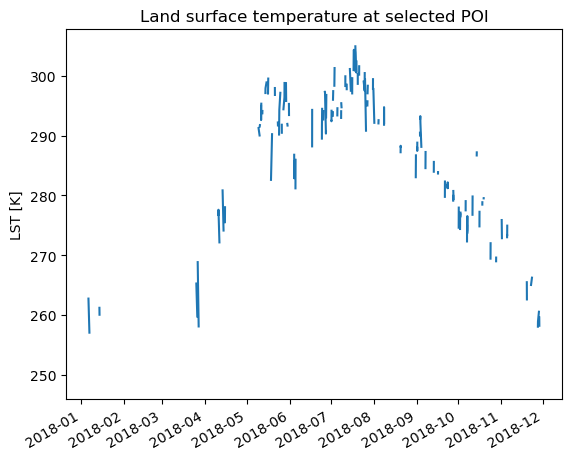

In [199]:
# plot the obtained LST
LST_concat.plot();
plt.title('Land surface temperature at selected POI');
plt.ylabel('LST [K]')
plt.xlabel('');

In [200]:
spring_concat = LST_concat.sel(time=slice('2018-03', '2018-05'))

In [201]:
daily_cycle_spring_concat = spring_concat.groupby("time.hour").mean("time")

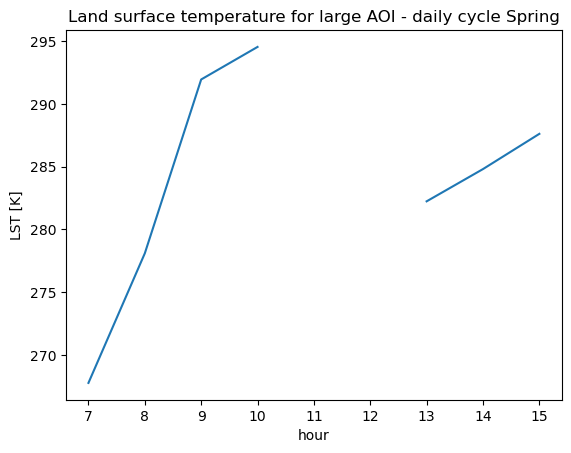

In [202]:
# plot the obtained LST
daily_cycle_spring_concat.plot();
plt.title('Land surface temperature for large AOI - daily cycle Spring');
plt.ylabel('LST [K]');

In [203]:
# you can do the same in summer

summer_concat = LST_concat.sel(time=slice('2018-06', '2018-08'))

In [204]:
daily_cycle_summer_concat = summer_concat.groupby("time.hour").mean("time")

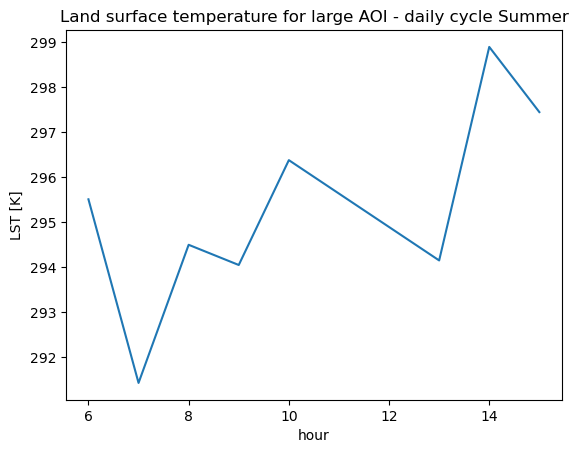

In [205]:
# plot the obtained LST
daily_cycle_summer_concat.plot();
plt.title('Land surface temperature for large AOI - daily cycle Summer');
plt.ylabel('LST [K]');